In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
!ls

datalab


In [0]:
import os

if 'drive' in os.listdir():
    COLAB=True
    os.chdir('drive/dl-projects/transfer-learning-quora/notebooks/')

import sys
sys.path.append('..')

In [0]:
import torch
from fastai.text import *
from pathlib import Path
import dill as pickle
from src.dataloader import PairedDataset, PairedEmbedDataset
from sklearn.model_selection import StratifiedShuffleSplit

DATA = Path('../data/')
LM = DATA/'language-model/'
CLS = DATA/'classifier/'
TMP = DATA/'tmp'

if COLAB:  
    WT = Path('/content/models/wt103/')
else:
    WT = DATA/'wt/models/wt103/'

### 1. Load vocabulary and classifier data.

In [0]:
# Tokenized text
qntok = np.load(CLS/'cls_trn.npy')
qnlabels = np.load(CLS/'cls_trn_lbl.npy').astype(np.float32)

# Split into training and validation sets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
trn_idx, val_idx = next(iter(sss.split(qntok, qnlabels)))

trn, trn_lbl = qntok[trn_idx], qnlabels[trn_idx]
val, val_lbl = qntok[val_idx], qnlabels[val_idx]

# Load vocab
itos = pickle.load((DATA/'itos.p').open('rb'))
stoi = pickle.load((DATA/'stoi.p').open('rb'))
vs = len(itos)

### 2. Load End-to-End Similarity Net

In [0]:
class MultiTwoBatchRNN(MultiBatchRNN):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        super().__init__(bptt, max_seq, *args, **kwargs)
        super().reset()
        
    def forward(self, input):
        raw_outputs1, outputs1 = super().forward(input[0])
        raw_outputs2, outputs2 = super().forward(input[1])

        return raw_outputs1, outputs1, raw_outputs2, outputs2 


class PoolingDiffLinearClassifier(PoolingLinearClassifier):
    def get_final_embedding(self, outputs):
        output = outputs[-1]
        sl, bs, _ = output.size()
        avgpool = self.pool(output, bs, False)
        mxpool = self.pool(output, bs, True)

        return torch.cat([output[-1], mxpool, avgpool], 1)
    
    def forward(self, x):
        raw_outputs1, outputs1, raw_outputs2, outputs2 = x
        x1 = self.get_final_embedding(outputs1)
        x2 = self.get_final_embedding(outputs2)
        x = (x1 - x2).abs()

        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
            
        return l_x.view(-1)


class MultiSequentialRNN(SequentialRNN):
    def forward(self, *input):
        for module in self._modules.values():
            input = module(input)
        return input

    
def get_question_siml_model(bptt, max_seq, n_tok, emb_sz, n_hid, nlayers, pad_token, layers, drops, bidir=False,
                            dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
                           
    birnn_enc = MultiTwoBatchRNN(bptt, max_seq, n_tok, emb_sz=emb_sz, nhid=n_hid, nlayers=nlayers, pad_token=pad_token, bidir=bidir,
                                 dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    
    sim_net = PoolingDiffLinearClassifier(layers, drops)
    
    return MultiSequentialRNN(birnn_enc, sim_net)

In [0]:
class PairedDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __getitem__(self, i):
        return A(self.x[i, 0], (self.x[i, 1]), self.y[i])
    
    def __len__(self):
        return self.y.shape[0]

In [0]:
# Model config
wd = 1e-7
bptt = 70
bs = 48
pad_tok = 1
em_sz, nh, nl = 400, 1150, 3
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

# Make datasets and dataloaders
trn_ds = PairedDataset(trn, trn_lbl)
val_ds = PairedDataset(val, val_lbl)

# transpose_y is currently a hack to transpose the second question as well. Submit PR to fastai!
trn_dl = DataLoader(trn_ds, bs//2, num_workers=1, pad_idx=1, shuffle=True, transpose=True, 
                    transpose_y=True, pre_pad=False)
val_dl = DataLoader(val_ds, bs, num_workers=1, pad_idx=1, shuffle=False, transpose=True, 
                    transpose_y=True, pre_pad=False)

# Make model data
md = ModelData(TMP, trn_dl, val_dl)

# Similarity net
simnet = get_question_siml_model(bptt, 20*70, vs, em_sz, nh, nlayers=nl, 
                                 pad_token=1, layers=[em_sz*3, 512, 128, 1], 
                                 drops=[dps[4], 0.15, 0.1], dropouti=dps[0],
                                 wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, TextModel(to_gpu(simnet)), crit=F.binary_cross_entropy_with_logits, opt_fn=optim.Adam, metrics=[accuracy_thresh(0.5)])

learn.load_encoder('lm1_enc')
learn.freeze_to(-1)

### 3. Start Training

#### Only head

In [258]:
wd=1e-7
learn.lr_find(1e-5, 5, wds=wd)

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  0%|          | 42/15161 [00:05<31:37,  7.97it/s, loss=0.689]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 125/15161 [00:15<30:34,  8.20it/s, loss=0.684]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 164/15161 [00:20<30:29,  8.20it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|▏         | 206/15161 [00:25<30:32,  8.16it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 245/15161 [00:30<30:30,  8.15it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 327/15161 [00:40<30:17,  8.16it/s, loss=0.676]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 407/15161 [00:50<30:16,  8.12it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 449/15161 [00:55<30:10,  8.13it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 488/15161 [01:00<30:05,  8.13it/s, loss=0.668]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 567/15161 [01:10<30:05,  8.08it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 610/15161 [01:15<29:54,  8.11it/s, loss=0.656]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 649/15161 [01:20<29:51,  8.10it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 730/15161 [01:30<29:41,  8.10it/s, loss=0.657]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 772/15161 [01:35<29:34,  8.11it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 811/15161 [01:40<29:31,  8.10it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 853/15161 [01:45<29:25,  8.11it/s, loss=0.65]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 893/15161 [01:50<29:18,  8.11it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 933/15161 [01:55<29:16,  8.10it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 973/15161 [02:00<29:11,  8.10it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1096/15161 [02:15<28:55,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1135/15161 [02:20<28:51,  8.10it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1175/15161 [02:25<28:48,  8.09it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1215/15161 [02:30<28:42,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1257/15161 [02:35<28:36,  8.10it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▊         | 1297/15161 [02:40<28:31,  8.10it/s, loss=0.63]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1338/15161 [02:45<28:26,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1377/15161 [02:50<28:22,  8.10it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1503/15161 [03:05<28:02,  8.12it/s, loss=0.642]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1542/15161 [03:10<27:58,  8.11it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1623/15161 [03:20<27:49,  8.11it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1663/15161 [03:25<27:45,  8.11it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1744/15161 [03:35<27:35,  8.10it/s, loss=0.627]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1782/15161 [03:40<27:32,  8.10it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1825/15161 [03:45<27:25,  8.10it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1905/15161 [03:55<27:17,  8.10it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1944/15161 [04:00<27:12,  8.10it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1988/15161 [04:05<27:05,  8.11it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2025/15161 [04:10<27:02,  8.10it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2066/15161 [04:15<26:57,  8.09it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2107/15161 [04:20<26:51,  8.10it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2183/15161 [04:30<26:46,  8.08it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2222/15161 [04:35<26:42,  8.08it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2263/15161 [04:40<26:36,  8.08it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2303/15161 [04:45<26:32,  8.08it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2340/15161 [04:50<26:29,  8.07it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2382/15161 [04:55<26:23,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2424/15161 [05:00<26:17,  8.08it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2466/15161 [05:05<26:11,  8.08it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2505/15161 [05:10<26:06,  8.08it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2547/15161 [05:15<26:01,  8.08it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2703/15161 [05:35<25:44,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2781/15161 [05:45<25:36,  8.06it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2866/15161 [05:55<25:23,  8.07it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2908/15161 [06:00<25:17,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2948/15161 [06:05<25:13,  8.07it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 2987/15161 [06:10<25:08,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3026/15161 [06:15<25:04,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3064/15161 [06:20<25:00,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3105/15161 [06:25<24:55,  8.06it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3144/15161 [06:30<24:51,  8.06it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3183/15161 [06:35<24:47,  8.05it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3263/15161 [06:45<24:37,  8.05it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3301/15161 [06:50<24:33,  8.05it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3342/15161 [06:55<24:28,  8.05it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3381/15161 [07:00<24:23,  8.05it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3423/15161 [07:05<24:18,  8.05it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3502/15161 [07:15<24:08,  8.05it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3536/15161 [07:20<24:07,  8.03it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3577/15161 [07:25<24:01,  8.03it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3618/15161 [07:30<23:56,  8.04it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3660/15161 [07:35<23:50,  8.04it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3698/15161 [07:40<23:46,  8.04it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3739/15161 [07:45<23:41,  8.04it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3778/15161 [07:50<23:36,  8.04it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3819/15161 [07:55<23:31,  8.04it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3857/15161 [08:00<23:27,  8.03it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3896/15161 [08:05<23:22,  8.03it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3937/15161 [08:10<23:17,  8.03it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 3980/15161 [08:15<23:11,  8.04it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4063/15161 [08:25<23:00,  8.04it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4104/15161 [08:30<22:54,  8.04it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4146/15161 [08:35<22:48,  8.05it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4187/15161 [08:40<22:42,  8.05it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4231/15161 [08:45<22:36,  8.05it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4313/15161 [08:55<22:26,  8.06it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4396/15161 [09:05<22:15,  8.06it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4437/15161 [09:10<22:09,  8.07it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4480/15161 [09:15<22:03,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|██▉       | 4517/15161 [09:20<21:59,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4560/15161 [09:25<21:54,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4599/15161 [09:30<21:49,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4641/15161 [09:35<21:44,  8.07it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4682/15161 [09:40<21:38,  8.07it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4844/15161 [10:00<21:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4886/15161 [10:05<21:12,  8.07it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4925/15161 [10:10<21:08,  8.07it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5010/15161 [10:20<20:56,  8.08it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5050/15161 [10:25<20:51,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5089/15161 [10:30<20:46,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5128/15161 [10:35<20:42,  8.07it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5168/15161 [10:40<20:37,  8.07it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5210/15161 [10:45<20:32,  8.07it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5252/15161 [10:50<20:26,  8.08it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5289/15161 [10:55<20:22,  8.07it/s, loss=0.58]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5328/15161 [11:00<20:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5367/15161 [11:05<20:14,  8.07it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5404/15161 [11:10<20:09,  8.06it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5483/15161 [11:20<20:00,  8.06it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▋      | 5524/15161 [11:25<19:55,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5564/15161 [11:30<19:50,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5684/15161 [11:45<19:35,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5723/15161 [11:50<19:31,  8.06it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5805/15161 [12:00<19:20,  8.06it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5846/15161 [12:05<19:15,  8.06it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5887/15161 [12:10<19:10,  8.06it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5930/15161 [12:15<19:04,  8.06it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6009/15161 [12:25<18:55,  8.06it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6050/15161 [12:30<18:49,  8.06it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6132/15161 [12:40<18:39,  8.07it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6175/15161 [12:45<18:33,  8.07it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6215/15161 [12:50<18:28,  8.07it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6257/15161 [12:55<18:23,  8.07it/s, loss=0.587]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6297/15161 [13:00<18:18,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6373/15161 [13:10<18:09,  8.07it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6455/15161 [13:20<17:59,  8.07it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6497/15161 [13:25<17:53,  8.07it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6536/15161 [13:30<17:49,  8.07it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6616/15161 [13:40<17:39,  8.07it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6657/15161 [13:45<17:34,  8.07it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6739/15161 [13:55<17:23,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6779/15161 [14:00<17:18,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6821/15161 [14:05<17:13,  8.07it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6862/15161 [14:10<17:08,  8.07it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6943/15161 [14:20<16:57,  8.07it/s, loss=0.575]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6986/15161 [14:25<16:52,  8.07it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7027/15161 [14:30<16:47,  8.08it/s, loss=0.588]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7070/15161 [14:35<16:41,  8.08it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7110/15161 [14:40<16:36,  8.08it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7151/15161 [14:45<16:31,  8.08it/s, loss=0.594]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7317/15161 [15:05<16:10,  8.08it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7357/15161 [15:10<16:05,  8.08it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7399/15161 [15:15<16:00,  8.08it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7565/15161 [15:35<15:39,  8.09it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7690/15161 [15:50<15:23,  8.09it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7731/15161 [15:55<15:18,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7770/15161 [16:00<15:13,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7811/15161 [16:05<15:08,  8.09it/s, loss=0.584]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7847/15161 [16:10<15:04,  8.09it/s, loss=0.592]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7928/15161 [16:20<14:54,  8.09it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7971/15161 [16:25<14:48,  8.09it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8007/15161 [16:30<14:44,  8.09it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8049/15161 [16:35<14:39,  8.09it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8167/15161 [16:50<14:25,  8.08it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8210/15161 [16:55<14:19,  8.09it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8251/15161 [17:00<14:14,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8293/15161 [17:05<14:09,  8.09it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8333/15161 [17:10<14:04,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8375/15161 [17:15<13:58,  8.09it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8415/15161 [17:20<13:53,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8458/15161 [17:25<13:48,  8.09it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8539/15161 [17:35<13:38,  8.09it/s, loss=0.586]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8579/15161 [17:40<13:33,  8.09it/s, loss=0.591]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8621/15161 [17:45<13:28,  8.09it/s, loss=0.589]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8659/15161 [17:50<13:23,  8.09it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8700/15161 [17:55<13:18,  8.09it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8821/15161 [18:10<13:03,  8.09it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8863/15161 [18:15<12:58,  8.09it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8901/15161 [18:20<12:53,  8.09it/s, loss=0.59]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8943/15161 [18:25<12:48,  8.09it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8982/15161 [18:30<12:43,  8.09it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9060/15161 [18:40<12:34,  8.09it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9140/15161 [18:50<12:24,  8.09it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9181/15161 [18:55<12:19,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9220/15161 [19:00<12:14,  8.09it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9261/15161 [19:05<12:09,  8.09it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9303/15161 [19:10<12:04,  8.09it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9346/15161 [19:15<11:58,  8.09it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9424/15161 [19:25<11:49,  8.09it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9462/15161 [19:30<11:44,  8.09it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9543/15161 [19:40<11:34,  8.09it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9582/15161 [19:45<11:30,  8.08it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9703/15161 [20:00<11:15,  8.08it/s, loss=0.633]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9746/15161 [20:05<11:09,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▍   | 9825/15161 [20:15<11:00,  8.08it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9867/15161 [20:20<10:54,  8.09it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9907/15161 [20:25<10:49,  8.09it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9949/15161 [20:30<10:44,  8.09it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9991/15161 [20:35<10:39,  8.09it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10032/15161 [20:40<10:34,  8.09it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10071/15161 [20:45<10:29,  8.09it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10112/15161 [20:50<10:24,  8.09it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10151/15161 [20:55<10:19,  8.09it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10232/15161 [21:05<10:09,  8.09it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10272/15161 [21:10<10:04,  8.09it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10316/15161 [21:15<09:58,  8.09it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10397/15161 [21:25<09:48,  8.09it/s, loss=0.653]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10514/15161 [21:40<09:34,  8.09it/s, loss=0.651]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10554/15161 [21:45<09:29,  8.09it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10592/15161 [21:50<09:25,  8.09it/s, loss=0.664]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10632/15161 [21:55<09:20,  8.08it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10671/15161 [22:00<09:15,  8.08it/s, loss=0.664]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10714/15161 [22:05<09:10,  8.08it/s, loss=0.669]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10753/15161 [22:10<09:05,  8.08it/s, loss=0.761]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10795/15161 [22:15<09:00,  8.08it/s, loss=0.733]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10835/15161 [22:20<08:55,  8.08it/s, loss=0.717]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10877/15161 [22:25<08:49,  8.09it/s, loss=0.765]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10915/15161 [22:30<08:45,  8.08it/s, loss=0.764]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10958/15161 [22:35<08:39,  8.09it/s, loss=0.749]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 10996/15161 [22:40<08:35,  8.08it/s, loss=0.741]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11035/15161 [22:45<08:30,  8.08it/s, loss=0.743]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11076/15161 [22:50<08:25,  8.08it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11115/15161 [22:55<08:20,  8.08it/s, loss=0.693]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11155/15161 [23:00<08:15,  8.08it/s, loss=0.69]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11197/15161 [23:05<08:10,  8.08it/s, loss=0.699]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11237/15161 [23:10<08:05,  8.08it/s, loss=0.814]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11317/15161 [23:20<07:55,  8.08it/s, loss=0.812]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11359/15161 [23:25<07:50,  8.08it/s, loss=0.756]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11399/15161 [23:30<07:45,  8.08it/s, loss=0.769]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11441/15161 [23:35<07:40,  8.08it/s, loss=0.781]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11480/15161 [23:40<07:35,  8.08it/s, loss=0.882]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11523/15161 [23:45<07:29,  8.08it/s, loss=0.868]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11563/15161 [23:50<07:25,  8.08it/s, loss=0.834]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11606/15161 [23:55<07:19,  8.09it/s, loss=1.22]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11645/15161 [24:00<07:14,  8.09it/s, loss=1.4]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11768/15161 [24:15<06:59,  8.09it/s, loss=0.874]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11809/15161 [24:20<06:54,  8.09it/s, loss=0.927]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11852/15161 [24:25<06:49,  8.09it/s, loss=0.94]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11894/15161 [24:30<06:43,  8.09it/s, loss=1.15]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11935/15161 [24:35<06:38,  8.09it/s, loss=1.27]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11975/15161 [24:40<06:33,  8.09it/s, loss=1.01]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12017/15161 [24:45<06:28,  8.09it/s, loss=0.917]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12057/15161 [24:50<06:23,  8.09it/s, loss=0.857]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12217/15161 [25:10<06:03,  8.09it/s, loss=1.28]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12258/15161 [25:15<05:58,  8.09it/s, loss=2.12]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12262/15161 [25:15<05:58,  8.09it/s, loss=2.37]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


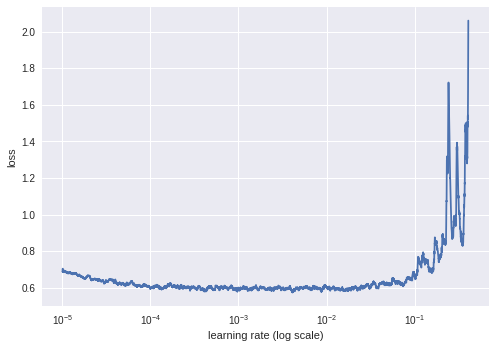

In [259]:
learn.sched.plot()

In [260]:
learn.fit(1e-5, 1, cycle_len=1, wds=wd, use_clr=(10, 3))

  0%|          | 34/15161 [00:04<31:59,  7.88it/s, loss=0.705]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 77/15161 [00:09<30:52,  8.14it/s, loss=0.698]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 115/15161 [00:14<31:03,  8.07it/s, loss=0.693]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  1%|          | 158/15161 [00:19<30:44,  8.13it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 234/15161 [00:29<31:15,  7.96it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 272/15161 [00:34<31:17,  7.93it/s, loss=0.706]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 311/15161 [00:39<31:23,  7.88it/s, loss=0.696]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  2%|▏         | 349/15161 [00:44<31:16,  7.89it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 390/15161 [00:49<31:10,  7.90it/s, loss=0.699]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 430/15161 [00:54<30:57,  7.93it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 473/15161 [00:59<30:44,  7.96it/s, loss=0.702]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  3%|▎         | 514/15161 [01:04<30:32,  7.99it/s, loss=0.697]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▎         | 556/15161 [01:09<30:23,  8.01it/s, loss=0.698]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 640/15161 [01:19<30:02,  8.06it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  4%|▍         | 678/15161 [01:24<30:01,  8.04it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▍         | 757/15161 [01:34<29:53,  8.03it/s, loss=0.687]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  5%|▌         | 799/15161 [01:39<29:46,  8.04it/s, loss=0.691]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 840/15161 [01:44<29:38,  8.05it/s, loss=0.694]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 882/15161 [01:49<29:31,  8.06it/s, loss=0.686]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▌         | 923/15161 [01:54<29:22,  8.08it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  6%|▋         | 965/15161 [01:59<29:16,  8.08it/s, loss=0.692]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1043/15161 [02:09<29:11,  8.06it/s, loss=0.688]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1081/15161 [02:14<29:09,  8.05it/s, loss=0.682]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  7%|▋         | 1125/15161 [02:19<28:59,  8.07it/s, loss=0.68]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1206/15161 [02:29<28:48,  8.07it/s, loss=0.684]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  8%|▊         | 1247/15161 [02:34<28:41,  8.08it/s, loss=0.686]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1329/15161 [02:44<28:30,  8.09it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1371/15161 [02:49<28:24,  8.09it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


  9%|▉         | 1410/15161 [02:54<28:19,  8.09it/s, loss=0.679]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1450/15161 [02:59<28:16,  8.08it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|▉         | 1490/15161 [03:04<28:10,  8.08it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 10%|█         | 1531/15161 [03:09<28:06,  8.08it/s, loss=0.68]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1615/15161 [03:19<27:53,  8.10it/s, loss=0.674]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1653/15161 [03:24<27:49,  8.09it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█         | 1696/15161 [03:29<27:43,  8.10it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 11%|█▏        | 1736/15161 [03:34<27:37,  8.10it/s, loss=0.677]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1776/15161 [03:39<27:33,  8.10it/s, loss=0.678]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1816/15161 [03:44<27:27,  8.10it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 12%|█▏        | 1860/15161 [03:49<27:20,  8.11it/s, loss=0.67]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1901/15161 [03:54<27:14,  8.11it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1943/15161 [03:59<27:09,  8.11it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 1984/15161 [04:04<27:02,  8.12it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 13%|█▎        | 2026/15161 [04:09<26:56,  8.12it/s, loss=0.672]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▎        | 2065/15161 [04:14<26:53,  8.12it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2107/15161 [04:19<26:47,  8.12it/s, loss=0.673]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2146/15161 [04:24<26:42,  8.12it/s, loss=0.665]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 14%|█▍        | 2188/15161 [04:29<26:37,  8.12it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2228/15161 [04:34<26:32,  8.12it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▍        | 2269/15161 [04:39<26:27,  8.12it/s, loss=0.658]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2304/15161 [04:44<26:26,  8.10it/s, loss=0.667]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 15%|█▌        | 2347/15161 [04:49<26:20,  8.11it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2387/15161 [04:54<26:15,  8.11it/s, loss=0.666]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▌        | 2428/15161 [04:59<26:10,  8.11it/s, loss=0.66]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 16%|█▋        | 2468/15161 [05:04<26:05,  8.11it/s, loss=0.654]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2554/15161 [05:14<25:51,  8.12it/s, loss=0.671]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2596/15161 [05:19<25:45,  8.13it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 17%|█▋        | 2636/15161 [05:24<25:41,  8.13it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2677/15161 [05:29<25:36,  8.12it/s, loss=0.661]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2759/15161 [05:39<25:25,  8.13it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 18%|█▊        | 2798/15161 [05:44<25:21,  8.13it/s, loss=0.658]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▊        | 2841/15161 [05:49<25:15,  8.13it/s, loss=0.659]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 19%|█▉        | 2925/15161 [05:59<25:03,  8.14it/s, loss=0.653]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|█▉        | 3004/15161 [06:09<24:55,  8.13it/s, loss=0.662]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3045/15161 [06:14<24:49,  8.13it/s, loss=0.657]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 20%|██        | 3087/15161 [06:19<24:43,  8.14it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3127/15161 [06:24<24:38,  8.14it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██        | 3206/15161 [06:34<24:30,  8.13it/s, loss=0.652]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 21%|██▏       | 3248/15161 [06:39<24:25,  8.13it/s, loss=0.651]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3288/15161 [06:44<24:20,  8.13it/s, loss=0.654]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3330/15161 [06:49<24:14,  8.13it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 22%|██▏       | 3369/15161 [06:54<24:10,  8.13it/s, loss=0.65]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3450/15161 [07:04<24:00,  8.13it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 23%|██▎       | 3529/15161 [07:14<23:51,  8.13it/s, loss=0.647]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▎       | 3571/15161 [07:19<23:46,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3611/15161 [07:24<23:41,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3651/15161 [07:29<23:36,  8.12it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 24%|██▍       | 3692/15161 [07:34<23:31,  8.13it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▍       | 3770/15161 [07:44<23:22,  8.12it/s, loss=0.649]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 25%|██▌       | 3852/15161 [07:54<23:12,  8.12it/s, loss=0.64]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3931/15161 [08:04<23:03,  8.12it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▌       | 3973/15161 [08:09<22:58,  8.12it/s, loss=0.645]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 26%|██▋       | 4012/15161 [08:14<22:53,  8.12it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4052/15161 [08:19<22:49,  8.11it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 27%|██▋       | 4135/15161 [08:29<22:38,  8.12it/s, loss=0.641]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4176/15161 [08:34<22:33,  8.12it/s, loss=0.644]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4219/15161 [08:39<22:27,  8.12it/s, loss=0.639]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4260/15161 [08:44<22:21,  8.12it/s, loss=0.646]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 28%|██▊       | 4302/15161 [08:49<22:16,  8.12it/s, loss=0.643]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4386/15161 [08:59<22:05,  8.13it/s, loss=0.646]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4427/15161 [09:04<21:59,  8.13it/s, loss=0.636]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 29%|██▉       | 4467/15161 [09:09<21:55,  8.13it/s, loss=0.638]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 30%|███       | 4591/15161 [09:24<21:39,  8.14it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4672/15161 [09:34<21:29,  8.13it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███       | 4715/15161 [09:39<21:23,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 31%|███▏      | 4755/15161 [09:44<21:18,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4800/15161 [09:49<21:12,  8.14it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 32%|███▏      | 4841/15161 [09:54<21:07,  8.15it/s, loss=0.631]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 4962/15161 [10:09<20:52,  8.14it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 33%|███▎      | 5003/15161 [10:14<20:47,  8.14it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▎      | 5086/15161 [10:24<20:36,  8.15it/s, loss=0.633]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5129/15161 [10:29<20:31,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5170/15161 [10:34<20:25,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 34%|███▍      | 5211/15161 [10:39<20:20,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5251/15161 [10:44<20:15,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▍      | 5292/15161 [10:49<20:11,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 35%|███▌      | 5333/15161 [10:54<20:05,  8.15it/s, loss=0.628]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5414/15161 [11:04<19:56,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5454/15161 [11:09<19:51,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 36%|███▌      | 5495/15161 [11:14<19:46,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5537/15161 [11:19<19:41,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5578/15161 [11:24<19:35,  8.15it/s, loss=0.632]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 37%|███▋      | 5621/15161 [11:29<19:30,  8.15it/s, loss=0.634]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5703/15161 [11:39<19:20,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5781/15161 [11:49<19:11,  8.15it/s, loss=0.635]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 38%|███▊      | 5821/15161 [11:54<19:06,  8.15it/s, loss=0.63]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▊      | 5863/15161 [11:59<19:01,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 39%|███▉      | 5904/15161 [12:04<18:55,  8.15it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|███▉      | 6025/15161 [12:19<18:41,  8.15it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 40%|████      | 6109/15161 [12:29<18:30,  8.15it/s, loss=0.631]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6150/15161 [12:34<18:25,  8.15it/s, loss=0.637]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6190/15161 [12:39<18:20,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████      | 6233/15161 [12:44<18:14,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 41%|████▏     | 6275/15161 [12:49<18:09,  8.15it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6315/15161 [12:54<18:04,  8.16it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6358/15161 [12:59<17:59,  8.16it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6397/15161 [13:04<17:54,  8.16it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 42%|████▏     | 6439/15161 [13:09<17:49,  8.16it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6519/15161 [13:19<17:39,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 43%|████▎     | 6557/15161 [13:24<17:35,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▎     | 6596/15161 [13:29<17:31,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6638/15161 [13:34<17:25,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6680/15161 [13:39<17:20,  8.15it/s, loss=0.626]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 44%|████▍     | 6720/15161 [13:44<17:15,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▍     | 6760/15161 [13:49<17:10,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6841/15161 [13:59<17:00,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 45%|████▌     | 6882/15161 [14:04<16:55,  8.15it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6923/15161 [14:09<16:50,  8.15it/s, loss=0.625]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▌     | 6963/15161 [14:14<16:45,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 46%|████▋     | 7045/15161 [14:24<16:35,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7086/15161 [14:29<16:30,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 47%|████▋     | 7125/15161 [14:34<16:26,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7203/15161 [14:44<16:17,  8.14it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7245/15161 [14:49<16:11,  8.15it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7281/15161 [14:54<16:07,  8.14it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 48%|████▊     | 7322/15161 [14:59<16:02,  8.14it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▊     | 7359/15161 [15:04<15:58,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 49%|████▉     | 7444/15161 [15:14<15:47,  8.14it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7528/15161 [15:24<15:37,  8.14it/s, loss=0.623]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|████▉     | 7570/15161 [15:29<15:31,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7612/15161 [15:34<15:26,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 50%|█████     | 7653/15161 [15:39<15:21,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7695/15161 [15:44<15:16,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████     | 7737/15161 [15:49<15:11,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 51%|█████▏    | 7778/15161 [15:54<15:05,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7819/15161 [15:59<15:00,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7859/15161 [16:04<14:56,  8.15it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7900/15161 [16:09<14:51,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 52%|█████▏    | 7939/15161 [16:14<14:46,  8.15it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 7982/15161 [16:19<14:40,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8021/15161 [16:24<14:36,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8065/15161 [16:29<14:30,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 53%|█████▎    | 8103/15161 [16:34<14:26,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 54%|█████▍    | 8225/15161 [16:49<14:11,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▍    | 8309/15161 [16:59<14:00,  8.15it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8350/15161 [17:04<13:55,  8.15it/s, loss=0.622]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 55%|█████▌    | 8389/15161 [17:09<13:51,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8470/15161 [17:19<13:41,  8.15it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▌    | 8511/15161 [17:24<13:36,  8.15it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 56%|█████▋    | 8552/15161 [17:29<13:31,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8634/15161 [17:39<13:20,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 57%|█████▋    | 8673/15161 [17:44<13:16,  8.15it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8757/15161 [17:54<13:05,  8.15it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8798/15161 [17:59<13:00,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 58%|█████▊    | 8841/15161 [18:04<12:55,  8.15it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▊    | 8882/15161 [18:09<12:50,  8.15it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8922/15161 [18:14<12:45,  8.15it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 8963/15161 [18:19<12:40,  8.15it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 59%|█████▉    | 9003/15161 [18:24<12:35,  8.15it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9046/15161 [18:29<12:29,  8.15it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|█████▉    | 9086/15161 [18:34<12:25,  8.15it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9127/15161 [18:39<12:20,  8.15it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 60%|██████    | 9162/15161 [18:44<12:16,  8.15it/s, loss=0.601]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9205/15161 [18:49<12:10,  8.15it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████    | 9244/15161 [18:54<12:06,  8.15it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 61%|██████▏   | 9287/15161 [18:59<12:00,  8.15it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9328/15161 [19:04<11:55,  8.15it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9371/15161 [19:09<11:50,  8.15it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 62%|██████▏   | 9456/15161 [19:19<11:39,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9496/15161 [19:24<11:34,  8.16it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9539/15161 [19:29<11:29,  8.16it/s, loss=0.624]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9579/15161 [19:34<11:24,  8.16it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 63%|██████▎   | 9622/15161 [19:39<11:18,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▎   | 9663/15161 [19:44<11:13,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9706/15161 [19:49<11:08,  8.16it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 64%|██████▍   | 9748/15161 [19:54<11:03,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 65%|██████▌   | 9911/15161 [20:14<10:43,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9950/15161 [20:19<10:38,  8.16it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 9991/15161 [20:24<10:33,  8.16it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▌   | 10034/15161 [20:29<10:28,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 66%|██████▋   | 10074/15161 [20:34<10:23,  8.16it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 67%|██████▋   | 10114/15161 [20:39<10:18,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10235/15161 [20:54<10:03,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10318/15161 [21:04<09:53,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 68%|██████▊   | 10359/15161 [21:09<09:48,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▊   | 10400/15161 [21:14<09:43,  8.16it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10482/15161 [21:24<09:33,  8.16it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 69%|██████▉   | 10521/15161 [21:29<09:28,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|██████▉   | 10560/15161 [21:34<09:23,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10643/15161 [21:44<09:13,  8.16it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 70%|███████   | 10683/15161 [21:49<09:08,  8.16it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████   | 10723/15161 [21:54<09:03,  8.16it/s, loss=0.619]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 71%|███████▏  | 10805/15161 [22:04<08:53,  8.16it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10847/15161 [22:09<08:48,  8.16it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10888/15161 [22:14<08:43,  8.16it/s, loss=0.618]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10929/15161 [22:19<08:38,  8.16it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 72%|███████▏  | 10970/15161 [22:24<08:33,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11013/15161 [22:29<08:28,  8.16it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11053/15161 [22:34<08:23,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 73%|███████▎  | 11094/15161 [22:39<08:18,  8.16it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▎  | 11178/15161 [22:49<08:08,  8.16it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11219/15161 [22:54<08:02,  8.16it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 74%|███████▍  | 11261/15161 [22:59<07:57,  8.16it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▍  | 11303/15161 [23:04<07:52,  8.16it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11387/15161 [23:14<07:42,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 75%|███████▌  | 11432/15161 [23:19<07:36,  8.17it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11471/15161 [23:24<07:31,  8.17it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▌  | 11515/15161 [23:29<07:26,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 76%|███████▋  | 11598/15161 [23:39<07:16,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11639/15161 [23:44<07:11,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 77%|███████▋  | 11681/15161 [23:49<07:05,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11765/15161 [23:59<06:55,  8.17it/s, loss=0.615]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11807/15161 [24:04<06:50,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11848/15161 [24:09<06:45,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 78%|███████▊  | 11885/15161 [24:14<06:40,  8.17it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▊  | 11927/15161 [24:19<06:35,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 11964/15161 [24:24<06:31,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12008/15161 [24:29<06:25,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 79%|███████▉  | 12046/15161 [24:34<06:21,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|███████▉  | 12089/15161 [24:39<06:15,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 80%|████████  | 12130/15161 [24:44<06:10,  8.17it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12212/15161 [24:54<06:00,  8.17it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12253/15161 [24:59<05:55,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 81%|████████  | 12294/15161 [25:04<05:50,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12377/15161 [25:14<05:40,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12420/15161 [25:19<05:35,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12456/15161 [25:24<05:31,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 82%|████████▏ | 12497/15161 [25:29<05:26,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 83%|████████▎ | 12537/15161 [25:34<05:21,  8.17it/s, loss=0.617]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▎ | 12662/15161 [25:49<05:05,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 84%|████████▍ | 12744/15161 [25:59<04:55,  8.17it/s, loss=0.629]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12827/15161 [26:09<04:45,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▍ | 12867/15161 [26:14<04:40,  8.17it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12908/15161 [26:19<04:35,  8.17it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 85%|████████▌ | 12947/15161 [26:24<04:30,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 12989/15161 [26:29<04:25,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13029/15161 [26:34<04:20,  8.17it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 86%|████████▌ | 13070/15161 [26:39<04:15,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13154/15161 [26:49<04:05,  8.17it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13195/15161 [26:54<04:00,  8.17it/s, loss=0.599]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 87%|████████▋ | 13236/15161 [26:59<03:55,  8.17it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13276/15161 [27:04<03:50,  8.17it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13320/15161 [27:09<03:45,  8.17it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13360/15161 [27:14<03:40,  8.17it/s, loss=0.614]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 88%|████████▊ | 13402/15161 [27:19<03:35,  8.17it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▊ | 13440/15161 [27:24<03:30,  8.17it/s, loss=0.612]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13483/15161 [27:29<03:25,  8.17it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 89%|████████▉ | 13522/15161 [27:34<03:20,  8.17it/s, loss=0.616]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|████████▉ | 13605/15161 [27:44<03:10,  8.17it/s, loss=0.62]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 90%|█████████ | 13649/15161 [27:49<03:04,  8.18it/s, loss=0.621]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13730/15161 [27:59<02:55,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████ | 13771/15161 [28:04<02:50,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 91%|█████████▏| 13852/15161 [28:14<02:40,  8.18it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13894/15161 [28:19<02:34,  8.18it/s, loss=0.605]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 13973/15161 [28:29<02:25,  8.17it/s, loss=0.593]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 92%|█████████▏| 14013/15161 [28:34<02:20,  8.17it/s, loss=0.606]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14056/15161 [28:39<02:15,  8.17it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14097/15161 [28:44<02:10,  8.17it/s, loss=0.596]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 93%|█████████▎| 14139/15161 [28:49<02:05,  8.18it/s, loss=0.6]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▎| 14181/15161 [28:54<01:59,  8.18it/s, loss=0.597]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14225/15161 [28:59<01:54,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14265/15161 [29:04<01:49,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 94%|█████████▍| 14307/15161 [29:09<01:44,  8.18it/s, loss=0.61]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▍| 14386/15161 [29:19<01:34,  8.18it/s, loss=0.607]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14425/15161 [29:24<01:30,  8.18it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 95%|█████████▌| 14469/15161 [29:29<01:24,  8.18it/s, loss=0.613]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 96%|█████████▌| 14548/15161 [29:39<01:14,  8.18it/s, loss=0.611]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14673/15161 [29:54<00:59,  8.18it/s, loss=0.602]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14715/15161 [29:59<00:54,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 97%|█████████▋| 14755/15161 [30:04<00:49,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14797/15161 [30:09<00:44,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14837/15161 [30:14<00:39,  8.18it/s, loss=0.609]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14879/15161 [30:19<00:34,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 98%|█████████▊| 14918/15161 [30:24<00:29,  8.18it/s, loss=0.608]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▊| 14959/15161 [30:29<00:24,  8.18it/s, loss=0.604]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 14998/15161 [30:34<00:19,  8.18it/s, loss=0.603]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15040/15161 [30:39<00:14,  8.18it/s, loss=0.595]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


 99%|█████████▉| 15081/15161 [30:44<00:09,  8.18it/s, loss=0.598]

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/usr/local

epoch      trn_loss   val_loss   <lambda>   
    0      0.603525   0.589881   0.640506  


[array([0.58988]), 0.640506408591445]

In [261]:
learn.save('clas_lst')

/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)


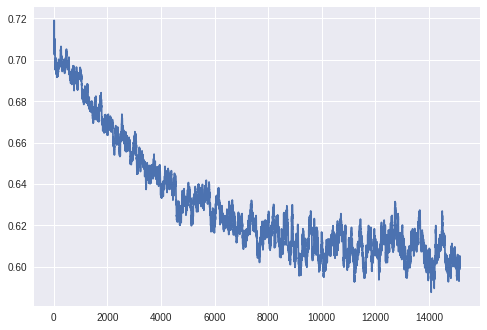

In [262]:
learn.sched.plot_loss()

#### End-to-end

In [0]:
learn.unfreeze()
learn.clip=0.25

In [0]:
wd=1e-9
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

learn.lr_find(lrs, 5, wds=wd)

epoch      trn_loss   val_loss   <lambda>                          
    0      0.352894   0.365291   0.634687  



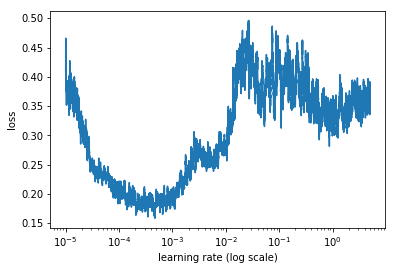

In [0]:
learn.sched.plot()

In [0]:

learn.fit(1e-3, 1, cycle_len=10, wds=wd, use_clr=(20, 10))

 18%|█▊        | 8277/45483 [15:31<1:11:39,  8.65it/s, loss=0.169]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 33%|███▎      | 14807/45483 [27:59<55:41,  9.18it/s, loss=0.187]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 46%|████▋     | 21117/45483 [40:53<45:27,  8.93it/s, loss=0.159]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 27701/45483 [53:13<34:03,  8.70it/s, loss=0.166]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch      trn_loss   val_loss   <lambda>                          
    0      0.177286   0.166694   0.756099  
    1      0.155282   0.151198   0.783085                          
    2      0.155447   0.14315    0.797317                             
    3      0.135215   0.134182   0.809281                          
    4      0.126106   0.131003   0.816199                          
    5      0.11934    0.128975   0.817461                          
    6      0.129097   0.124911   0.823853                           
    7      0.099743   0.122613   0.827462                           
    8      0.111978   0.120179   0.832059                           
 67%|██████▋   | 30376/45483 [55:01<27:35,  9.12it/s, loss=0.101]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    9      0.104227   0.119319   0.834887                           



[array([0.11932]), 0.8348869027884517]

In [0]:
nn_evaluate(md.val_dl, learn.model)

Accuracy:  0.8335848029879542
Negative Log loss:  0.38575378046816444
             precision    recall  f1-score   support

        0.0       0.86      0.88      0.87     25503
        1.0       0.78      0.76      0.77     14926

avg / total       0.83      0.83      0.83     40429



In [0]:
learn.lr_find(1e-9, 2, wds=wd)

 76%|███████▋  | 34757/45483 [1:05:32<18:51,  9.48it/s, loss=0.294]  

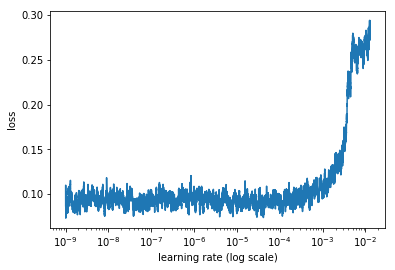

In [0]:
learn.sched.plot()

In [0]:
learn.fit(1e-5, 1, cycle_len=10, wds=wd, use_clr=(20, 10))

  0%|          | 1/45483 [00:00<1:41:28,  7.47it/s, loss=0.0467]   
epoch      trn_loss   val_loss   <lambda>                           
    0      0.0817     0.119357   0.834726  
    1      0.089166   0.119577   0.834874                           
 29%|██▉       | 13098/45483 [23:05<58:55,  9.16it/s, loss=0.0903]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 52%|█████▏    | 23630/45483 [41:36<37:49,  9.63it/s, loss=0.0852]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 63%|██████▎   | 28732/45483 [50:37<30:56,  9.02it/s, loss=0.0889]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 69%|██████▉   | 31406/45483 [55:18<24:56,  9.41it/s, loss=0.0873]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|████████  | 36517/45483 [1:04:17<15:34,  9.59it/s, loss=0.0988]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87%|████████▋ | 39463/45483 [1:09:29<11:07,  9.02it/s, loss=0.0841]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98%|█████████▊| 44562/45483 [1:18:30<01:36,  9.58it/s, loss=0.0997]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  3%|▎         | 1485/45483 [02:41<1:22:43,  8.86it/s, loss=0.0882]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 13%|█▎        | 5931/45483 [11:00<1:17:05,  8.55it/s, loss=0.0856]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 18%|█▊        | 8119/45483 [15:01<1:07:11,  9.27it/s, loss=0.0959]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 30%|███       | 13779/45483 [25:28<54:45,  9.65it/s, loss=0.101]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45%|████▍     | 20283/45483 [37:29<46:34,  9.02it/s, loss=0.092]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59%|█████▉    | 26978/45483 [49:58<33:59,  9.07it/s, loss=0.0873]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|███████▉  | 36261/45483 [1:07:08<17:05,  8.99it/s, loss=0.0961]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      0.086451   0.119861   0.834361                           
  3%|▎         | 1210/45483 [02:15<1:16:30,  9.64it/s, loss=0.11]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 17%|█▋        | 7704/45483 [14:21<1:07:31,  9.32it/s, loss=0.0873]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32%|███▏      | 14396/45483 [26:48<57:48,  8.96it/s, loss=0.088]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 47%|████▋     | 21252/45483 [39:20<45:57,  8.79it/s, loss=0.0916]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 27825/45483 [51:37<31:51,  9.24it/s, loss=0.0822]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 76%|███████▌  | 34364/45483 [1:03:52<21:52,  8.47it/s, loss=0.0919]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|█████████ | 40959/45483 [1:16:12<08:33,  8.82it/s, loss=0.0946]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    4      0.097393   0.119768   0.835045                           
  5%|▍         | 2190/45483 [04:04<1:14:42,  9.66it/s, loss=0.0891]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 20%|█▉        | 8935/45483 [16:34<1:05:29,  9.30it/s, loss=0.0955]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 54%|█████▍    | 24771/45483 [45:52<37:16,  9.26it/s, loss=0.0994]  